In [1]:
import datetime

from gensim.models import KeyedVectors
from gensim.test import test_data
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
questions_en = '/home/levai/.miniconda3/envs/gensim/lib/python3.8/site-packages/gensim/test/test_data/questions-words.txt'

In [3]:
questions = '/mnt/permanent/Language/Hungarian/Embed/questions-words-hu/questions-words-hu.txt'

In [4]:
vectors_en = KeyedVectors.load('/mnt/permanent/Language/English/Embed/glove.840B.300d.gensim')

In [5]:
vectors = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/mnsz2/glf/mnsz-glf-sgram-600.gensim')

In [6]:
def get_analogy_scores(vectors, questions):
    score, sections = vectors.evaluate_word_analogies(questions, restrict_vocab=10000)
    #print(score)
    df_ = pd.DataFrame(sections)
    df_.set_index('section', inplace=True)
    df = df_.apply({'correct': len, 'incorrect': len})
    df['total'] = df.sum(axis=1)
    df['accuracy'] = df.correct / df.total
    df.drop(index=['Total accuracy'], inplace=True)
    return df

# English

In [7]:
df_en = get_analogy_scores(vectors_en, questions_en)

In [8]:
df = get_analogy_scores(vectors, questions)

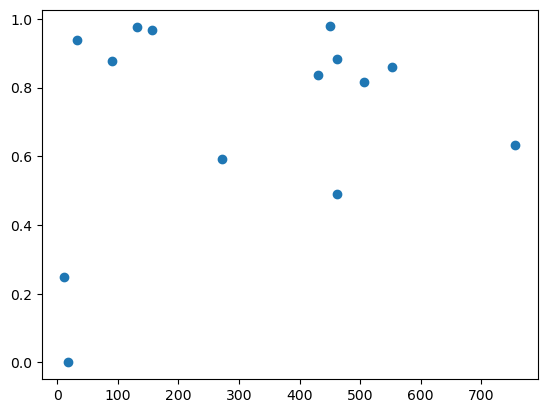

In [9]:
plt.scatter(df_en.total, df_en.accuracy)

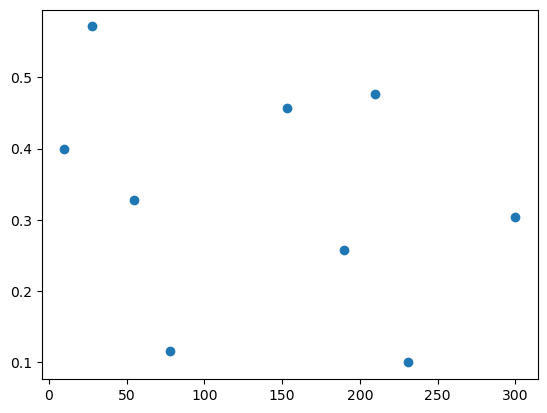

In [10]:
plt.scatter(df.total, df.accuracy)

# Webcorpus 2.0: gluten-free and vanila

In [11]:
def aggregate_score(model):
    df = get_analogy_scores(model, questions)
    df.drop(index=['capital-world', 'capital-common-countries'], inplace=True)
    # capital-world is disregarded because large OOV make this relation instabile
    # [~df.index.str.startswith('gram')]
    return df.accuracy.mean()

In [12]:
embed_dir = '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0'

In [21]:
file_patterns = ['2017_2018_2956', '2017_2018_295', '2017_2018_29', 'wiki', '2017_2018_2', '2017_2018']#, '201', ''
def get_accuracy_by_size():
    for file_pattern in file_patterns:
        for deglutinate_ in ['vanila', 'deglut', 'deglutAllSuffSepd']:
            try:
                model = KeyedVectors.load(f'{embed_dir}/sgns-300-{file_pattern}-{deglutinate_}.gensim')
            except FileNotFoundError:
                continue
            record = {
                'files': f'{file_pattern}*',
                'deglut' : deglutinate_,
                'sentence': model.corpus_count, 
                'token': model.corpus_total_words, 
                'type': len(model.wv.key_to_index)}
            df = get_analogy_scores(model.wv, questions)
            record['capital-common-countries'] = df.loc['capital-common-countries']
            df.drop(index=['capital-world', 'capital-common-countries'], inplace=True)
            record['accuracy'] = df.accuracy.mean()
            print(record)
            yield record

In [22]:
records = get_accuracy_by_size()

In [ ]:
df_ = pd.DataFrame(records)

{'files': '2017_2018_2956*', 'deglut': 'vanila', 'sentence': 66798, 'token': 894741, 'type': 9388, 'capital-common-countries': correct      0.0
incorrect    0.0
total        0.0
accuracy     NaN
Name: capital-common-countries, dtype: float64, 'accuracy': 0.000649772579597141}
{'files': '2017_2018_2956*', 'deglut': 'deglut', 'sentence': 66798, 'token': 1192818, 'type': 6739, 'capital-common-countries': correct      0.0
incorrect    1.0
total        1.0
accuracy     0.0
Name: capital-common-countries, dtype: float64, 'accuracy': 0.03333333333333333}
{'files': '2017_2018_2956*', 'deglut': 'deglutAllSuffSepd', 'sentence': 66798, 'token': 1246317, 'type': 6576, 'capital-common-countries': correct      0.0
incorrect    1.0
total        1.0
accuracy     0.0
Name: capital-common-countries, dtype: float64, 'accuracy': 0.016666666666666666}
{'files': '2017_2018_295*', 'deglut': 'vanila', 'sentence': 879317, 'token': 16948301, 'type': 149981, 'capital-common-countries': correct      0.0
incorrect

In [ ]:
df_

In [ ]:
df = df_.drop(columns=['deglut', 'accuracy']).groupby('files').max()
df = df.join(pd.pivot_table(df_, values='accuracy', index='files', columns='deglut'), rsuffix='_')
df.sort_values('sentence', inplace=True)

In [ ]:
def thousand(int_):
    return f'{int_:,}'

In [ ]:
df.apply({col: thousand if col in ['sentence', 'token', 'type'] else lambda x: x for col in df.columns})

In [ ]:
df[['vanila', 'deglut', 'deglutAllSuffSepd']].plot()
_ = plt.xticks(rotation=90)


# Investigating the strange results

In [ ]:
def plot_accur_of_two_embeds(accuracies_vanila, accuracies_deglut, lname='vanila', rname='deglut', 
                             column='accuracy'):
    accuracies = accuracies_vanila.join(accuracies_deglut, rsuffix=f'-{rname}')
    plt.scatter(accuracies[f'{column}'], accuracies[f'{column}-{rname}'])
    plt.xlabel(lname)
    plt.ylabel(rname)
    for relation, stats in accuracies.iterrows():
        plt.annotate(relation, xy=(stats[f'{column}'], stats[f'{column}-{rname}']), rotation=45)

In [ ]:
def get_analogy_scores_wrapper(filen_suff, deglut):
    vecs = KeyedVectors.load(f'/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-{filen_suff}-{deglut}.gensim')
    return get_analogy_scores(vecs.wv, questions)

## Two kinds of deglut

### Greatest difference

In [ ]:
nemeskey = get_analogy_scores_wrapper('2017_2018_2', 'deglutAllSuffSepd')

In [ ]:
twopart = get_analogy_scores_wrapper('2017_2018_2', 'deglut')

In [ ]:
plot_accur_of_two_embeds(nemeskey, twopart, lname='nemeskey', rname='twopart', column='correct')

## Larger corpus is worse

## deglut 13G: `capital-common-countries` is worse in the larger corpus

### Nemeskey-style

In [ ]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018_2-deglutAllSuffSepd.gensim')
accur_3G = get_analogy_scores(vecs.wv, questions)

In [ ]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-deglutAllSuffSepd.gensim')
accur_13G = get_analogy_scores(vecs.wv, questions)

In [ ]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large')

In [ ]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large', column='correct')
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
accur_3G.loc['capital-common-countries']

In [ ]:
accur_13G.loc['capital-common-countries']

### two-part

In [ ]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018_2-deglut.gensim')
accur_3G = get_analogy_scores(vecs.wv, questions)

In [ ]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-deglut.gensim')
accur_13G = get_analogy_scores(vecs.wv, questions)

In [ ]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large')

In [ ]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large', column='correct')
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
accur_3G.loc['capital-common-countries']

In [ ]:
accur_13G.loc['capital-common-countries']

## Wiki vs similar-sized webcorpus

In [ ]:
wiki_vanl = get_analogy_scores_wrapper('wiki', 'vanila')
wiki_dg_nemeskey = get_analogy_scores_wrapper('wiki', 'deglutAllSuffSepd')
wiki_dg_twopart = get_analogy_scores_wrapper('wiki', 'deglut')
webcorp_vanl = get_analogy_scores_wrapper('2017_2018_29', 'vanila')
webcorp_dg_nemeskey = get_analogy_scores_wrapper('2017_2018_29', 'deglutAllSuffSepd')
webcorp_dg_twopart = get_analogy_scores_wrapper('2017_2018_29', 'deglut')

### vanila

In [ ]:
plot_accur_of_two_embeds(wiki_vanl, webcorp_vanl, lname='wiki', rname='web')

In [ ]:
plot_accur_of_two_embeds(wiki_vanl, webcorp_vanl, lname='wiki', rname='web', column='correct')

In [ ]:
wiki_vanl.loc['capital-common-countries']

In [ ]:
webcorp_vanl.loc['capital-common-countries']

### two-part

In [ ]:
plot_accur_of_two_embeds(wiki_dg_twopart, webcorp_dg_twopart, lname='wiki', rname='web')

In [ ]:
plot_accur_of_two_embeds(wiki_dg_twopart, webcorp_dg_twopart, lname='wiki', rname='web', column='correct')

## Nemeskey-style

In [ ]:
plot_accur_of_two_embeds(wiki_dg_nemeskey, webcorp_dg_nemeskey, lname='wiki', rname='web')

In [ ]:
plot_accur_of_two_embeds(wiki_dg_nemeskey, webcorp_dg_nemeskey, lname='wiki', rname='web', column='correct')

# Sanity check of the gluten-free embed

In [ ]:
vectors_vanila = KeyedVectors.load(
    '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-vanila.gensim').wv

In [ ]:
vectors_vanila.most_similar('menekít')

In [ ]:
accuracies_vanila = get_analogy_scores(vectors_vanila, questions)

In [ ]:
vectors_deglut = KeyedVectors.load(
    '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-deglut.gensim').wv

In [ ]:
vectors_deglut.most_similar('menekít')

In [ ]:
accuracies_deglut = get_analogy_scores(vectors_deglut, questions)